In [24]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick

from cycler import cycler
import sys, os, glob
import pytz

from scipy.signal import *
from scipy.stats import *



# use latex fonts/mathematica color scheme
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', family='Computer Modern Roman')

# cyclers for colors and line styles
line_cycle = cycler('linestyle', ["-","-.","--"])
color_cycle_trimmed = cycler('color', ["#5e81b5", "#e19c24", "#8fb032"])
color_cycle = cycler('color', ["#5e81b5", "#e19c24", "#8fb032", "#eb6235", "#8778b3", \
                                                    "#c56e1a", "#5d9ec7", "#ffbf00", "#a5609d", "#929600", \
                                                    "#e95536", "#6685d9", "#f89f13", "#bc5b80", "#47b66d"])

## RMS voltage noise PSD

First, we make figures for the PSD and calculate the integrated RMS noise over 1Hz - 100kHz.

### Data colleciton notes

Curves were taken on a stanfor research SR780 spectrum analyzer. A ~0.5Hz highpass filter acted as a DC block, and the instrument was DC coupled (-50dBV input sensitivity).

In [2]:
# # Here, we do data conditioning from raw export
# path = './data/raw'

# #datasets = [ ('50V JQI', '50'), ('100V JQI', '100'), ('200V JQI', '200'), ('100V Thorlabs', '100T'), \
# #                ('Background', 'BG-LPF-')]

# datasets = [ ('50V', '50'), ('100V', '100'), ('200V', '200'), ('Background', 'BG-LPF-')]

# _final_list = []
# for dataset in datasets:
#     _list = []
#     for file in glob.glob(os.path.join(path, dataset[1] + '[A-Z]*.asc')):
#         df = pd.read_csv(file, delim_whitespace=True, header=12, index_col=[0], dtype=np.float)
#         df.columns = [ os.path.basename(file).split('.')[0] ]
#         _list.append(df)
    
#     _data = pd.concat(_list, axis=1)
#     _data = pd.concat([_data[d] for d in _data.columns], join='outer').dropna().reset_index() \
#         .drop_duplicates(subset='X[Hz]').set_index('X[Hz]').sort_index().rename(columns={0: dataset[0]})
#     _final_list.append(_data)

# data = pd.concat(_final_list, axis=1)

# # save to csv
# data.to_csv('./data/NoisePSD_data.csv')

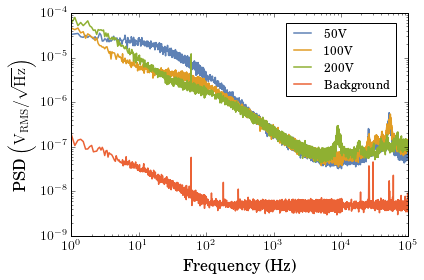

Rms (uV) 1 - 100000 Hz


[('50V', 137.65260817451556),
 ('100V', 80.177066196054255),
 ('200V', 101.47586739581907),
 ('Background', 1.7485167013438581)]

In [21]:
# import PSD data
psd = pd.read_csv('./data/NoisePSD_data.csv', index_col=0)

matplotlib.rc('axes', prop_cycle=color_cycle)

ax = psd.interpolate().plot(loglog=True, linewidth=1.5)    # must call .interpolate() here because background data is misaligned on X[Hz] 
                                        # with respect to the rest of the dataset. This causes a gap in the plot

plt.ylim([1e-9, 1e-4])
plt.xlim([1, 1e5])
ax.tick_params(labelsize=14)

#plt.title('RMS Voltage PSD', fontsize=18)
plt.legend(loc='upper right',  bbox_to_anchor=(0.98,0.98))
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.ylabel(r'PSD $\left(\mathrm{V_{RMS}} / \sqrt{\mathrm{Hz}}\right)$', fontsize=16)
plt.tight_layout()
plt.savefig('../fig/VoltagePSD.pdf')
plt.savefig('../fig/VoltagePSD.png', dpi=300)
plt.show()

rms_minFreq = 1
rms_maxFreq = 1e5
print("Rms (uV) %d - %d Hz" % (rms_minFreq, rms_maxFreq))
[(c, 1e6*np.sqrt(np.trapz((data[c][rms_minFreq:rms_maxFreq].interpolate())**2 , data[c][rms_minFreq:rms_maxFreq].index))) for c in data.columns]

## Bode Plot (modulation input transfer function)

Now, we make the bode plot figure. Raw data was exported from the Bode Plotter.

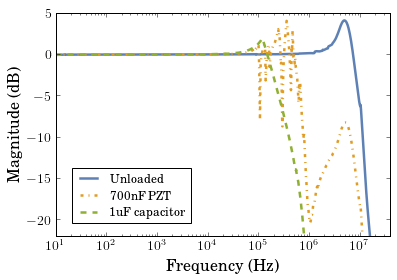

In [25]:
bode_raw = pd.read_csv('./data/ModulationInputBodePlot.csv', skiprows=20)

# grab relevant columns
bode = bode_raw.iloc[:,[0,6,9,12]]
bode.columns = ['freq', 'Unloaded', '700nF PZT', '1uF capacitor']
bode.set_index('freq', inplace=True)



matplotlib.rc('axes', prop_cycle=color_cycle_trimmed + line_cycle)


ax = bode.plot(logx=True, linewidth=2.5)

#plt.title("Modulation input transfer function", fontsize=18)
plt.ylim([-22, 5])
plt.ylabel("Magnitude (dB)", fontsize=16)
plt.xlabel("Frequency (Hz)", fontsize=16)

ax.tick_params(labelsize=14)

plt.legend(loc='lower left',  bbox_to_anchor=(0.03,0.03))
plt.savefig('../fig/PiezoModulationTransfer.pdf')
plt.savefig('../fig/PiezoModulationTransfer.png', dpi=300)
plt.show()

## Longterm trace in e-lab

We use this trace to extract a temperature coefficient in ppm/deg C.

Here, we compute the effective temperature coefficent from a (fortuitous) large temperature swing in the electronics room during a long-term trace on the kiethley.

             temperature         V
temperature     1.153040 -0.002428
V              -0.002428  0.000006
--------------------------
temperature coeff: -24.471853 ppm


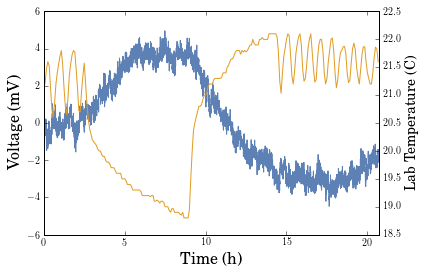

In [30]:
## Data conditioning
## Note: this data exists on google drive: https://drive.google.com/folderview?id=0B-YaJoP0pshJbmpWTG5tNWlFVUk

# longterm_rootdir = '~/Downloads/PiezoRSI/LongTermTrace_electronics_room'

# ## for pulling data from influxdb; ran once, exported to "large data" dump on Google Drive
# # from influxdb import InfluxDBClient, DataFrameClient

# # # fill in appropriately...
# # client = DataFrameClient('jqi-logger.physics.umd.edu', 8086, username=None, password=None, database=None)

# # # start, end time of long term trace on keithly
# # start_s = 1463527976
# # end_s = 1463602291

# # influxTemps = client.query('select "value" from "temperature" where "channel_name" =~ /Electronics Rm/ AND time > %ds AND time < %ds' % (start_s, end_s))
# # temps = influxTemps['temperature']
# # temps.index.rename('timestamp', inplace=True)
# # temps.rename(columns={'value': 'temperature'}, inplace=True)
# # temps.index = temps.index.tz_convert(pytz.timezone('US/Eastern'))

# # temps.to_csv(os.path.join(longterm_rootdir, "ExportedTemperatureData_InfluxDB.csv"))

# temps = pd.read_csv(os.path.join(longterm_rootdir, "ExportedTemperatureData_InfluxDB.csv"), index_col=0, parse_dates=True)
# temps.index = temps.index.tz_localize(pytz.utc)

# _list = []
# for f in glob.glob(os.path.join(longterm_rootdir, 'output_[0-9]*.csv')):
#     df = pd.read_csv(f, names = ["timestamp", "V"], header=None, index_col=0)
#     _list.append(df)

# # construct dataframe for voltages
# data_lt = pd.concat(_list, join='outer').sort_index()
# data_lt.index = pd.to_datetime(data_lt.index, unit='s').tz_localize(pytz.utc)                                                          

# # align temperature and voltage data, sampled every 10 seconds...
# combinedData = pd.concat([temps.resample('5T').mean(), data_lt.resample('10s').mean()], axis=1)

# # turn index into hours, offset from zero
# combinedData.index = combinedData.index.astype(np.int64)//10**9/3600.
# combinedData.index = combinedData.index - combinedData.index[0]

# # save to independent files...
# pd.DataFrame(combinedData.V.dropna()).to_csv(os.path.join(longterm_rootdir, 'voltage_data.csv'))
# pd.DataFrame(combinedData.temperature.dropna()).to_csv(os.path.join(longterm_rootdir, 'temperature_data.csv'))

volt = pd.read_csv('./data/voltage_data_electronics_room.csv', index_col=0)
temp = pd.read_csv('./data/temperature_data_electronics_room.csv', index_col=0)
long_t = volt.index # time coordinate

df = pd.concat([temp, volt], axis=1)

matplotlib.rc('axes', prop_cycle=color_cycle)

# subtract off mean value, plot
ax1 = ((df.V - df.V.mean())*1e3).plot()
ax1.set_ylabel("Voltage (mV)", fontsize=16)
ax1.set_xlabel("Time (h)", fontsize=16)

ax2 = df.temperature.dropna().plot(secondary_y=True)
ax2.set_ylabel("Lab Temperature (C)", fontsize=14)

corr = df.cov()
print(corr)

tempco = corr.V.temperature/df.V.mean()*1.0e6
print("--------------------------")
print("temperature coeff: %f ppm" % tempco)

# Time domain plots

In [53]:
## Condition data for longterm trace in lab
## this data exists on Google drive: https://drive.google.com/folderview?id=0B-YaJoP0pshJbmpWTG5tNWlFVUk

# longterm_rootdir = os.path.expanduser('~/Downloads/PiezoRSI/LongTermTrace_lab')

# # read in temperature data
# df = pd.read_csv(os.path.join(longterm_rootdir, 'temperatures.txt'), \
#                  header=None, names=['tsc', 'raw_dac', 'raw_voltage', 'resistance', 'temperature'])
# df['timestamp'], df['ch'] = zip(*df['tsc'].apply(lambda x: x.split('\t', 1)))
# del df['tsc']
# df.index = pd.to_datetime(df.timestamp)
# df.index = df.index.tz_localize('US/Eastern')
# temps = df[df.ch == '2'].temperature

# _list = []
# for f in glob.glob(os.path.join(longterm_rootdir, 'output_[0-9]*.csv')):
#     df = pd.read_csv(f, names = ["timestamp", "V"], header=None, index_col=0)
#     _list.append(df)

# # construct dataframe for voltages
# data_lt = pd.concat(_list, join='outer').sort_index()
# data_lt.index = pd.to_datetime(data_lt.index, unit='s').tz_localize(pytz.utc).tz_convert(pytz.timezone('US/Eastern'))


# # align temperature and voltage data, sampled every 10 seconds...
# combinedData = pd.concat([temps.resample('10s').mean(), data_lt.resample('10s').mean()], axis=1).dropna()

# # turn index into hours, offset from zero
# combinedData.index = combinedData.index.astype(np.int64)//10**9/3600.
# combinedData.index = combinedData.index - combinedData.index[0]

# data_dir = './data/'

# # save to independent files...
# pd.DataFrame(combinedData.V).to_csv(os.path.join(data_dir, 'voltage_data_lab.csv'))
# pd.DataFrame(combinedData.temperature).to_csv(os.path.join(data_dir, 'temperature_data_lab.csv'))

Now, the actual figure for the paper... combine short-term and long-term traces.

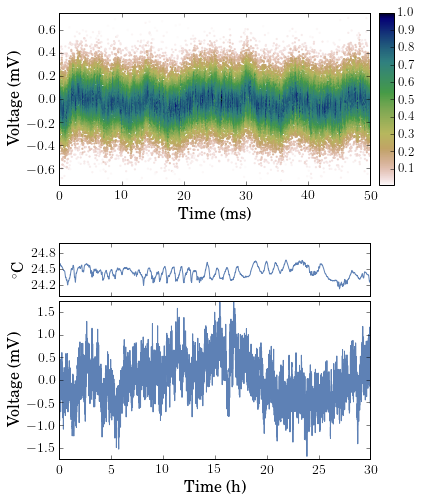

In [54]:
# # read and plot!

volt = pd.read_csv('./data/voltage_data_lab.csv', index_col=0)
temp = pd.read_csv('./data/temperature_data_lab.csv', index_col=0)
long_t = volt.index # time coordinate
 

# short-time trace
td = pd.read_csv('./data/timedomain.csv', index_col=0)

samples = 100000
binCnt = 500
ptTotal = td.voltage.size
binSize = ptTotal//binCnt

bins = np.split(td.voltage.values, np.arange(binSize, binSize*binCnt, binSize))

colorMap = []
for b in bins:
    gs = gaussian_kde(b)
    colorMap.extend(gs(b))

# downsample voltage values slightly; take only every 6th point to avoid overcrowding
y = td.voltage.values[::6]
c = colorMap[::6]
c = c/np.max(c) # Renorm to 0-1
short_t = np.linspace(0, 50, len(y))
    

    
# plotting...
matplotlib.rc('axes', prop_cycle=color_cycle)

f = plt.figure()
f.set_size_inches((6,8))

gs = gridspec.GridSpec(2, 2, height_ratios=[1,3], width_ratios=[20, 1])
gs_top = gridspec.GridSpec(1, 2, width_ratios=[20, 1])

ax_V = f.add_subplot(gs[1,0])
ax_temp = f.add_subplot(gs[0,0], sharex=ax_V)
ax_short = f.add_subplot(gs_top[0,0])
color_ax = plt.subplot(gs_top[0,1])

plt.setp(ax_temp.get_xticklabels(), visible=False)
plt.xlim([0,25])

ax_V.set_xlabel('Time (h)', fontsize=16)
ax_V.set_ylabel('Voltage (mV)', fontsize=16)
ax_V.plot(long_t, (volt - volt.mean())*1e3)

ax_V.set_ylim([-1.75,1.75])
ax_V.set_xlim([0,30])
ax_V.yaxis.set_ticks(np.linspace(-1.5,1.5,7))
ax_V.tick_params(labelsize=14)

ax_temp.set_ylabel('$^\circ$C', fontsize=16)
ax_temp.plot(temp.rolling(20).mean())

#ax_temp.set_ylim([22.9, 23.9])
ax_temp.set_ylim([24, 25])
ax_temp.yaxis.set_ticks(np.linspace(24.2,24.8,3))
ax_temp.tick_params(labelsize=14)


cnorm = matplotlib.colors.Normalize(vmin=np.min(c), vmax = np.max(c))
sc = ax_short.scatter(short_t, y, c=c, s=5, edgecolors='', cmap='gist_earth_r', norm=cnorm)
ax_short.set_xlim(0, 50)
ax_short.set_ylim(-0.75, 0.75)
ax_short.set_ylabel("Voltage (mV)", fontsize=16)
ax_short.set_xlabel("Time (ms)", fontsize=16)
ax_short.tick_params(labelsize=14)


f.colorbar(sc, cax=color_ax)
color_ax.tick_params(labelsize=13)

gs.update(top=0.5, hspace=0.05, wspace = 0.05)
gs_top.update(bottom=0.6, wspace = 0.05)


plt.savefig('../fig/TimeDomain.pdf')
plt.savefig('../fig/TimeDomain.png', dpi=300)
plt.show()

# Plotting of noise contributions (export from Mathematica)

See mathematica notebook for calculations; here, we plot the results for visual consistency with other figures.

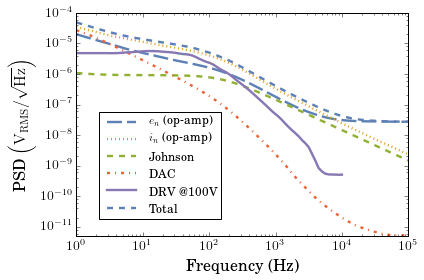

In [40]:
# import data calculated in mathematica...

noiseplt = pd.read_csv("./data/CalcNoiseContrib.csv", header=None, 
                       names=["s","$e_n$ (op-amp)", "$i_n$ (op-amp)", "Johnson", "DAC", "DRV @100V", "Total"], index_col=0)

# convert zeros to nans, really only matters for DRV noise plot (which extends out to 10kHz)
noiseplt["DRV @100V"] = noiseplt["DRV @100V"].replace(0, float('nan'))

color_cycle_noise = cycler('color', ["#5e81b5", "#e19c24", "#8fb032", "#eb6235", "#8778b3"])
line_cycle_noise = cycler('linestyle', ["--",":","--","-.","-"])

matplotlib.rc('axes', prop_cycle=color_cycle_noise + line_cycle_noise)

ax = noiseplt.plot(loglog=True, linewidth=2.4)

# update first trace to have long dashes -- bug in matplotlib 1.5.1 prevents doing this in cycler object.
handles, labels = ax.get_legend_handles_labels()
handles[0].set_linestyle((0,(15,5)))

# make ticks bigger
ax.tick_params(labelsize=14)

plt.xlim([1,1e5])
plt.ylim([5e-12,1e-4])

plt.legend(handles=handles, labels=labels, loc='lower left',  bbox_to_anchor=(0.05,0.05),handlelength=3)
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.ylabel(r'PSD $\left(\mathrm{V_{RMS}} / \sqrt{\mathrm{Hz}}\right)$', fontsize=16)

plt.tight_layout()
plt.savefig('../fig/NoiseContrib.pdf')
plt.savefig('../fig/NoiseContrib.png', dpi=300)
plt.show()

## DRV2700 voltage noise

Ouput of U2 measured on picoscope (spectrum mode; Hanning window, 1MS, 16384 bins, 4 decades, 10kHz span). At ~10kHz, we hit the noise floor of the instrument (~10e-7 V). This node is servoing the residual noise from the DRV2700, thus tells us the spectrum (ignoring the voltage noise associated with the op-amp, which will be negligible). To get a top-level spec on noise reduction, take 20\*log(Vdrv/Vout) over some bandwidth.

There does not seem to be any discernable difference between the "loaded" and "unloaded" output spectra, where "loaded" here has an additional 1uF cap. at the end of a BNC attached to the output. Let's look at a few different voltages:

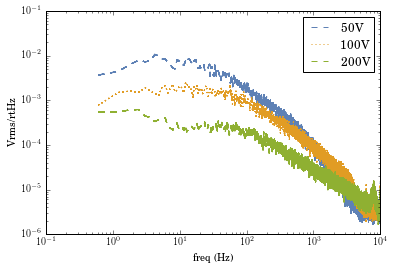

In [42]:
# 100V dataset
_list = []
for file in glob.glob("./data/raw/100V_FFT/*.csv"):
    df = pd.read_csv(file, skiprows=[1,2], index_col=0)
    df['Channel A'] = 10**(df['Channel A']/20)/np.sqrt(2) # convert from dBV to Vrms
    _list.append(df)

_data = pd.concat(_list, axis=1)
_data = pd.concat([_data[d] for d in _data.columns], join='outer')

# take average
FFT100V = _data.mean(axis=1)
# convert index to hertz
FFT100V.index = FFT100V.index*1e3
# convert to PSD units
FFT100V = FFT100V/np.sqrt(FFT100V.index[2])


# again for 200V
_list = []
for file in glob.glob("./data/raw/200V_FFT/*.csv"):
    df = pd.read_csv(file, skiprows=[1,2], index_col=0)
    df['Channel A'] = 10**(df['Channel A']/20)/np.sqrt(2) # convert from dBV to Vrms
    _list.append(df)

_data = pd.concat(_list, axis=1)
_data = pd.concat([_data[d] for d in _data.columns], join='outer')

# take average
FFT200V = _data.mean(axis=1)
# convert index to hertz
FFT200V.index = FFT200V.index*1e3
# convert to PSD units
FFT200V = FFT200V/np.sqrt(FFT200V.index[2])

# again for 50V
_list = []
for file in glob.glob("./data/raw/50V_FFT/*.csv"):
    df = pd.read_csv(file, skiprows=[1,2], index_col=0)
    df['Channel A'] = 10**(df['Channel A']/20)/np.sqrt(2) # convert from dBV to Vrms
    _list.append(df)

_data = pd.concat(_list, axis=1)
_data = pd.concat([_data[d] for d in _data.columns], join='outer')

# take average
FFT50V = _data.mean(axis=1)
# convert index to hertz
FFT50V.index = FFT50V.index*1e3
# convert to PSD units
FFT50V = FFT50V/np.sqrt(FFT50V.index[2])

plt.loglog(FFT50V.index, FFT50V.values, label="50V")
plt.loglog(FFT100V.index, FFT100V.values, label="100V")
plt.loglog(FFT200V.index, FFT200V.values, label="200V")
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Vrms/rtHz")
plt.savefig('DRVResidualNoise.png', dpi=300)
plt.show()